# Elo Merchant Category Recommendation - Autoencoder
End date: _2019. february 19._<br/>

This tutorial notebook is the second part of a seriers for [Elo Mechant Category Recommendation](https://www.kaggle.com/c/elo-merchant-category-recommendation) contest organized by Elo, one of the largest payment brands in Brazil. It has built partnerships with merchants in order to offer promotions or discounts to cardholders. The objective of the competition is to identify and serve the most relevant opportunities to individuals, by uncovering signals in customer loyalty. The input files are available from the [download](https://www.kaggle.com/c/elo-merchant-category-recommendation/data) section of the contest:

- **train.csv**,  **test.csv**: list of `card_ids` that can be used for training and testing
- **historical_transactions.csv**: contains up to 3 months' worth of transactions for every card at any of the provided `merchant_ids`
- **new_merchant_transactions.csv**: contains the transactions at new merchants (`merchant_ids` that this particular `card_id` 
has not yet visited) over a period of two months
- **merchants.csv**: contains aggregate information for each `merchant_id` represented in the data set

In [1]:
import gc
import math
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import tensorflow as tf
from pylab import rcParams
from keras import regularizers
import matplotlib.pyplot as plt
from keras.layers import Input, Dense
from keras.models import Model, load_model
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)
rcParams['figure.figsize'] = 14, 8

Using TensorFlow backend.


In [2]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Starting memory usage: {:5.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min >= np.iinfo(np.int8).min and c_max <= np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min >= np.iinfo(np.int16).min and c_max <= np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min >= np.iinfo(np.int32).min and c_max <= np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min >= np.iinfo(np.int64).min and c_max <= np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min >= np.finfo(np.float16).min and c_max <= np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min >= np.finfo(np.float32).min and c_max <= np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Reduced memory usage: {:5.2f} MB ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

## Loading the input data

In [3]:
df_merch = pd.read_csv("input/merchants.csv")
print("{:,} records and {} features in merchant set.".format(df_merch.shape[0], df_merch.shape[1]))

334,696 records and 22 features in merchant set.


In [4]:
df_merch['category_1'] = df_merch['category_1'].map({'N': 0, 'Y': 1})
df_merch['category_2'] = pd.to_numeric(df_merch['category_2'])
df_merch['category_4'] = df_merch['category_4'].map({'N': 0, 'Y': 1})
df_merch['most_recent_sales_range'] = df_merch['most_recent_sales_range'].map({'E': 0, 'D': 1, 'C': 2, 'B': 3, 'A': 4})
df_merch['most_recent_purchases_range'] = df_merch['most_recent_purchases_range'].map({'E': 0, 'D': 1, 'C': 2, 'B': 3, 'A': 4})

In [5]:
dropping = ['city_id', 'state_id']
for var in dropping:
    df_merch = df_merch.drop(var, axis=1)

In [6]:
df_merch = reduce_mem_usage(df_merch)

Starting memory usage: 51.07 MB
Reduced memory usage: 20.43 MB (60.0% reduction)


In [7]:
df_new_trans = pd.read_csv("input/trans_merch_new_agg.csv", index_col=0)
df_new_trans = reduce_mem_usage(df_new_trans)

df_hist_trans = pd.read_csv("input/trans_merch_hist_agg.csv", index_col=0)
df_hist_trans = reduce_mem_usage(df_hist_trans)

Starting memory usage: 354.01 MB
Reduced memory usage: 84.35 MB (76.2% reduction)
Starting memory usage: 397.39 MB
Reduced memory usage: 112.08 MB (71.8% reduction)


In [8]:
df_train = pd.read_csv("input/train.csv")
df_train = reduce_mem_usage(df_train)

df_test = pd.read_csv("input/test.csv")
df_test = reduce_mem_usage(df_test)

print("{:,} records and {} features in train set.".format(df_train.shape[0], df_train.shape[1]))
print("{:,} records and {} features in test set.".format(df_test.shape[0], df_test.shape[1]))

Starting memory usage:  9.24 MB
Reduced memory usage:  4.04 MB (56.2% reduction)
Starting memory usage:  4.72 MB
Reduced memory usage:  2.24 MB (52.5% reduction)
201,917 records and 6 features in train set.
123,623 records and 5 features in test set.


In [9]:
df_train = pd.merge(df_train, df_hist_trans, on='card_id',how='left')
df_test = pd.merge(df_test, df_hist_trans, on='card_id',how='left')

df_train = pd.merge(df_train, df_new_trans, on='card_id', how='left')
df_test = pd.merge(df_test, df_new_trans, on='card_id', how='left')

In [10]:
del df_hist_trans
del df_new_trans
gc.collect()

67

In [11]:
df_train[:3]

,first_active_month,card_id,feature_1,feature_2,feature_3,target,hist_transactions_count,hist_authorized_flag_sum,hist_authorized_flag_mean,hist_active_months_lag3_sum,...,new_purchase_dayofweek_max,new_purchase_dayofweek_min,new_purchase_dayofweek_std,new_purchase_dayofweek_mode,new_purchase_quarter_mean,new_purchase_quarter_median,new_purchase_quarter_max,new_purchase_quarter_min,new_purchase_quarter_std,new_purchase_quarter_mode
0,2017-06,C_ID_92a2005557,5,2,1,-0.820312,1,252.0,0.951172,777.0,...,6.0,0.0,2.029297,4.0,1.478516,1.0,2.0,1.0,0.510742,1.0
1,2017-01,C_ID_3d0044924f,4,1,0,0.392822,1,354.0,0.969727,1095.0,...,4.0,0.0,1.643555,0.0,1.000000,1.0,1.0,1.0,0.000000,1.0
2,2016-08,C_ID_d639edf6cd,2,2,0,0.687988,1,42.0,0.954590,132.0,...,5.0,5.0,NaN,5.0,2.000000,2.0,2.0,2.0,NaN,2.0


In [12]:
df_test[:3]

,first_active_month,card_id,feature_1,feature_2,feature_3,hist_transactions_count,hist_authorized_flag_sum,hist_authorized_flag_mean,hist_active_months_lag3_sum,hist_active_months_lag3_mean,...,new_purchase_dayofweek_max,new_purchase_dayofweek_min,new_purchase_dayofweek_std,new_purchase_dayofweek_mode,new_purchase_quarter_mean,new_purchase_quarter_median,new_purchase_quarter_max,new_purchase_quarter_min,new_purchase_quarter_std,new_purchase_quarter_mode
0,2017-04,C_ID_0ab67a22ab,3,3,1,1,47.0,0.662109,213.0,3.0,...,5.0,2.0,1.527344,2.0,1.000000,1.0,1.0,1.0,0.000000,1.0
1,2017-01,C_ID_130fd0cbdd,2,3,0,1,77.0,0.987305,234.0,3.0,...,6.0,0.0,2.359375,0.0,1.400391,1.0,2.0,1.0,0.516602,1.0
2,2017-08,C_ID_b709037bc5,5,1,1,1,9.0,0.692383,39.0,3.0,...,3.0,1.0,1.414062,1.0,1.000000,1.0,1.0,1.0,0.000000,1.0


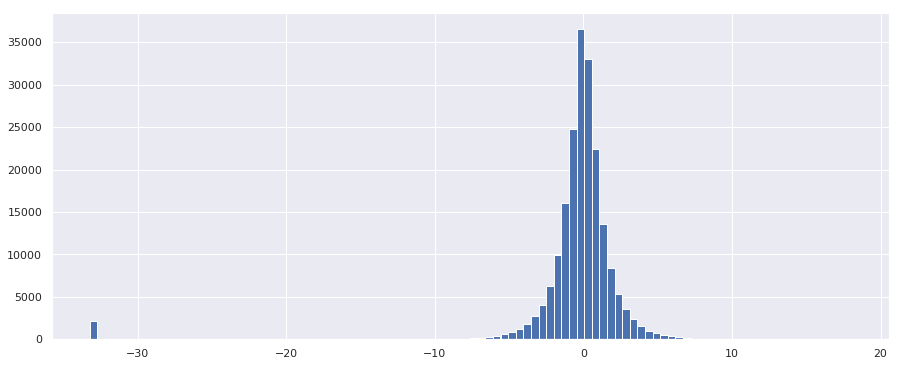

In [13]:
sns.set(rc={'figure.figsize':(15, 6)})

df_train['target'].hist(bins=100)

### Marking outliers

In [14]:
df_train['is_outlier'] = df_train['target'].apply(lambda x: 1 if x < -30 else 0)

In [15]:
len(df_train[df_train['is_outlier'] == 1]['is_outlier'])

2207

https://medium.com/@curiousily/credit-card-fraud-detection-using-autoencoders-in-keras-tensorflow-for-hackers-part-vii-20e0c85301bd

Text(0, 0.5, 'Frequency')

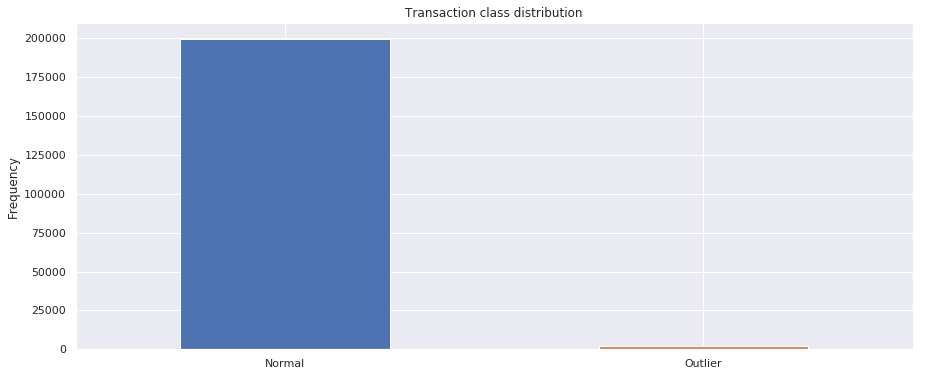

In [16]:
count_classes = pd.value_counts(df_train['is_outlier'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Transaction class distribution")
plt.xticks(range(2), ["Normal", "Outlier"])
plt.ylabel("Frequency")

## Filtering

In [17]:
df_train.drop(columns=['card_id', 'first_active_month', 'hist_merchant_id_mode', 'new_merchant_id_mode'], inplace=True, axis=1)
df_test.drop(columns=['card_id', 'first_active_month', 'hist_merchant_id_mode', 'new_merchant_id_mode'], inplace=True, axis=1)

In [18]:
len(df_train), len(df_test)

(201917, 123623)

In [19]:
df_train.dropna(how='any', axis=0, inplace=True)
df_test.dropna(how='any', axis=0, inplace=True)

In [20]:
len(df_train), len(df_test)

(147718, 90384)

In [21]:
for f in df_train.columns:
    if f != 'is_outlier':
        mean = df_train[f].mean()
        std = df_train[f].std()
        if math.isnan(mean):
            mean = df_train[f].astype(int).mean()
            std = df_train[f].astype(int).std()
    
        df_train[f] = (df_train[f] - mean)/std
        print('{}: {:.4f} ({:.4f})'.format(f, mean, std))

feature_1: 3.0877 (1.1951)
feature_2: 1.7326 (0.7500)
feature_3: 0.5543 (0.4970)
target: -0.4637 (3.0914)
hist_transactions_count: 1.0000 (0.0000)
hist_authorized_flag_sum: 96.7168 (111.3211)
hist_authorized_flag_mean: 0.1419 (0.3490)
hist_active_months_lag3_sum: 313.4754 (349.7907)
hist_active_months_lag3_mean: 2.9866 (0.1149)
hist_active_months_lag6_sum: 626.7824 (699.3774)
hist_active_months_lag6_mean: 5.9466 (0.2249)
hist_active_months_lag12_sum: 1229.6961 (1374.6195)
hist_active_months_lag12_mean: 11.1854 (0.4336)
hist_avg_sales_lag3_sum: 13026.3418 (150941.2031)
hist_avg_sales_lag3_mean: 130.5023 (1961.9861)
hist_avg_sales_lag6_sum: 12329.6572 (141868.8281)
hist_avg_sales_lag6_mean: 123.9150 (1847.1615)
hist_avg_sales_lag12_sum: 11424.0674 (138272.3594)
hist_avg_sales_lag12_mean: 114.8046 (1782.2146)
hist_avg_purchases_lag3_sum: inf (nan)
hist_avg_purchases_lag3_mean: inf (nan)
hist_avg_purchases_lag6_sum: inf (nan)
hist_avg_purchases_lag6_mean: inf (nan)
hist_avg_purchases_lag12

new_category_2_merch_mode: 2.2388 (1.5272)
new_category_2_merch_nancnt: 0.9026 (1.3522)
new_category_2_merch_nanperc: 11.9043 (16.9196)
new_category_3_sum: 4.6446 (7.0415)
new_category_3_mean: 0.5316 (0.5310)
new_category_3_mode: 0.5587 (0.5738)
new_category_3_nancnt: 0.0000 (0.0000)
new_category_3_nanperc: 3.1530 (9.2390)
new_category_4_sum: 4.0277 (5.1978)
new_category_4_mean: 0.2198 (0.4141)
new_city_id_nunique: 2.5745 (1.7250)
new_city_id_mode: 129.5956 (99.5631)
new_city_id_nancnt: 0.0000 (0.0000)
new_city_id_nanperc: 0.0000 (0.0000)
new_installments_sum: 5.4636 (9.0421)
new_installments_median: 0.5913 (0.7818)
new_installments_mean: 0.5650 (0.8297)
new_installments_max: 1.5609 (3.5678)
new_installments_min: 0.2161 (0.7393)
new_installments_std: 0.3332 (0.9593)
new_installments_mode: 0.5047 (0.7122)
new_installments_nancnt: 0.0000 (0.0000)
new_installments_nanperc: 0.0000 (0.0000)
new_merchant_id_nunique: 7.8263 (6.7674)
new_merchant_id_nancnt: 0.0976 (0.2971)
new_merchant_id_nanp

## Autoencoder

In [31]:
def SplitIntoTrainTestSet(df, cols, test_perc=0.2, verbose=True):
    X_train, X_test = train_test_split(df[cols], test_size=0.2, random_state=42)
    X_train = X_train[X_train['is_outlier'] == 0]
    X_train = X_train.drop(['is_outlier'], axis=1)

    y_test = X_test['is_outlier']

    X_test = X_test.drop(['is_outlier'], axis=1)
    X_train = X_train.values
    X_test = X_test.values
    
    if verbose:
        print('There are {:,} records and {} fetures in the training set and {:,} records and {} fetures in the test set.'.format(
            X_train.shape[0],
            X_train.shape[1],
            X_test.shape[0],
            X_test.shape[1]
        ))

    return X_train, X_test, y_test

def setupAutoencoder(input_dim, end_activation, structure, l1_alpha, verbose=False):
    input_layer = Input(shape=(input_dim, ), name='input_layer')
    layer = Dense(input_dim, activation=end_activation, activity_regularizer=regularizers.l1(l1_alpha))(input_layer)

    for i in range(0, len(structure)):
        layer = Dense(structure[i]['size'], activation=structure[i]['activation'])(layer)
        
    for i in range(len(structure)-1, -1, -1):
        layer = Dense(structure[i]['size'], activation=structure[i]['activation'])(layer)

    layer = Dense(input_dim, activation=end_activation, name='output')(layer)
    autoencoder = Model(inputs=input_layer, outputs=layer)

    if verbose:
        autoencoder.summary()
    
    return autoencoder

def trainModel(autoencoder, X_train, X_test, early_stopping=True, batch_size=32, nb_epoch=100, verbose=True):
    callbacks = []

    autoencoder.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
    if early_stopping:
        callbacks.append(EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto', baseline=None, restore_best_weights=False))

    #checkpointer = ModelCheckpoint(filepath="model.h5", verbose=0, save_best_only=True)
    #tensorboard = TensorBoard(log_dir='./logs', histogram_freq=0, write_graph=True, write_images=True)
    history = autoencoder.fit(X_train, X_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_test, X_test),
                    verbose=verbose,
                    callbacks=callbacks).history
    return history

def plotModellLoss(history):
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    plt.show()

def createReconstructionError(autoencoder, X_test, y_test):
    predictions = autoencoder.predict(X_test)
    mse = np.mean(np.power(X_test - predictions, 2), axis=1)
    error_df = pd.DataFrame({
        'reconstruction_error': mse,
        'true_class': y_test
    })
    return error_df

def plotReconstructionErrors(error_df):
    fig = plt.figure()
    ax = fig.add_subplot(211)

    normal_error_df = error_df[(error_df['true_class']== 0) & (error_df['reconstruction_error'] < 10)]
    fraud_error_df = error_df[error_df['true_class'] == 1]
    
    ax.hist(normal_error_df.reconstruction_error.values, bins=10)
    ax.set_title('Reconstruction error without outliers')

    ax = fig.add_subplot(212)
    ax.hist(fraud_error_df.reconstruction_error.values, bins=10)
    ax.set_title('Reconstruction error with outliers')
    plt.show()

def plotROCcurve(error_df):
    fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
    roc_auc = auc(fpr, tpr)

    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r--')
    plt.xlim([-0.001, 1])
    plt.ylim([0, 1.001])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

def plotRecallPrecisionCurve(error_df):
    precision, recall, th = precision_recall_curve(error_df.true_class, error_df.reconstruction_error)
    plt.plot(recall, precision, 'b', label='Precision-Recall curve')
    plt.title('Recall vs Precision')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.show()
    return precision, recall, th

def plotThresholdPrecisionCurve(th, precision):
    plt.plot(th, precision[1:], 'b', label='Threshold-Precision curve')
    plt.title('Precision for different threshold values')
    plt.xlabel('Threshold')
    plt.ylabel('Precision')
    plt.show()

def plotReconstructionErrorDataPoints(error_df, threshold):
    groups = error_df.groupby('true_class')
    fig, ax = plt.subplots()

    for name, group in groups:
        ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
                label= "Fraud" if name == 1 else "Normal")
    ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
    ax.legend()
    plt.title("Reconstruction error for different classes")
    plt.ylabel("Reconstruction error")
    plt.xlabel("Data point index")
    plt.show()

def drawConfusionMatrix(error_df, threshold):
    y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
    conf_matrix = confusion_matrix(error_df.true_class, y_pred)
    plt.figure(figsize=(12, 12))
    sns.heatmap(conf_matrix, xticklabels=["Normal", "Outlier"], yticklabels=["Normal", "Outlier"], annot=True, fmt="d");
    plt.title("Confusion matrix")
    plt.ylabel('True class')
    plt.xlabel('Predicted class')
    plt.show()

### tanh-2relu - 2relu-tanh (210 - 50 - 20 - 20 - 50 - 210)

There are 117,289 records and 210 fetures in the training set and 29,544 records and 210 fetures in the test set.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     (None, 210)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 210)               44310     
_________________________________________________________________
dense_21 (Dense)             (None, 50)                10550     
_________________________________________________________________
dense_22 (Dense)             (None, 20)                1020      
_________________________________________________________________
dense_23 (Dense)             (None, 20)                420       
_________________________________________________________________
dense_24 (Dense)             (None, 50)                1050      
____________________________

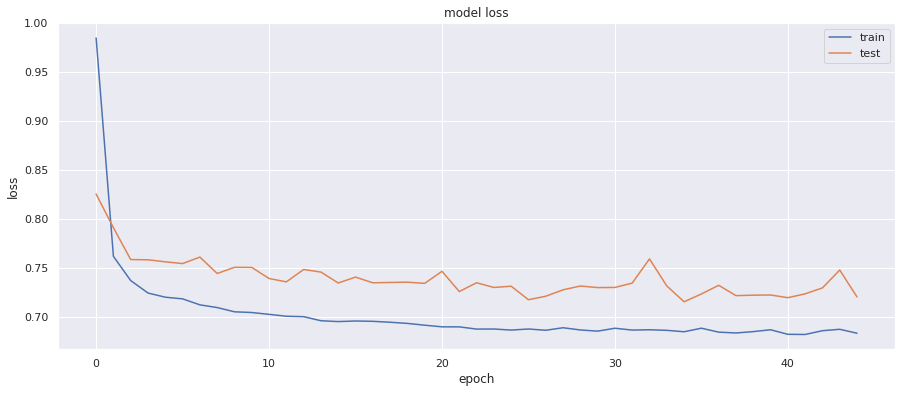

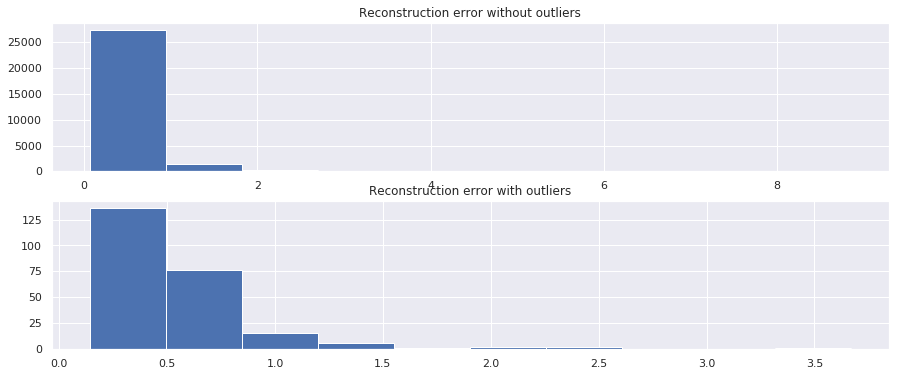

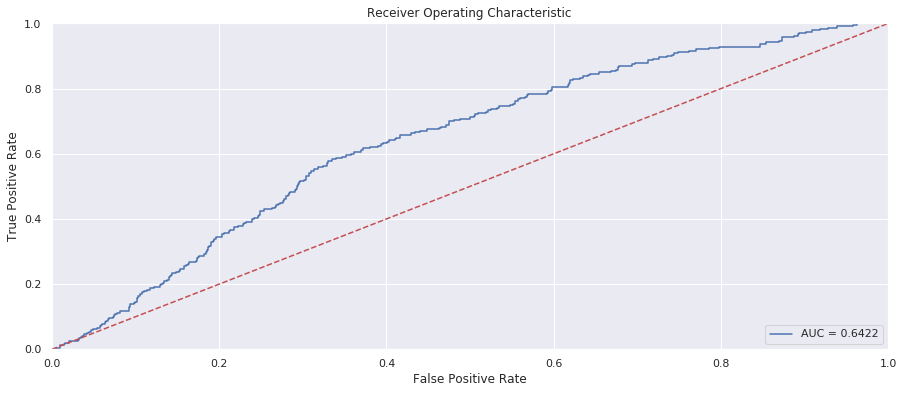

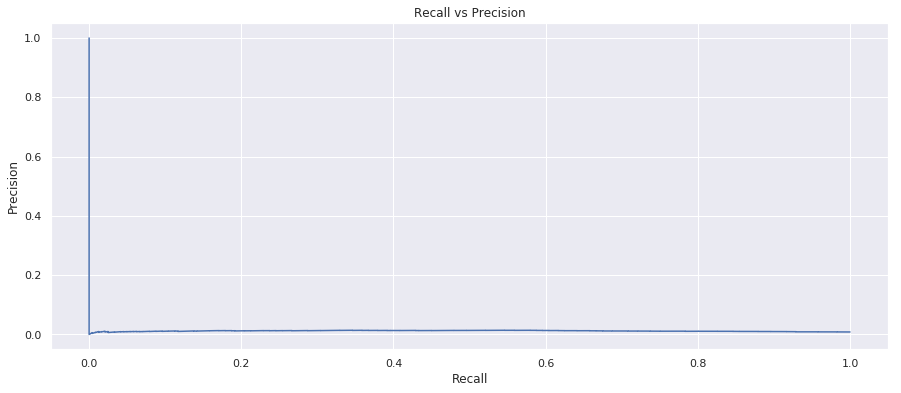

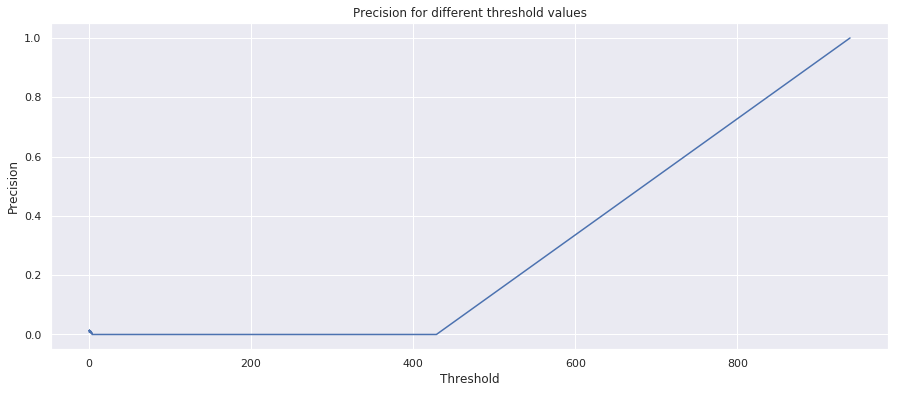

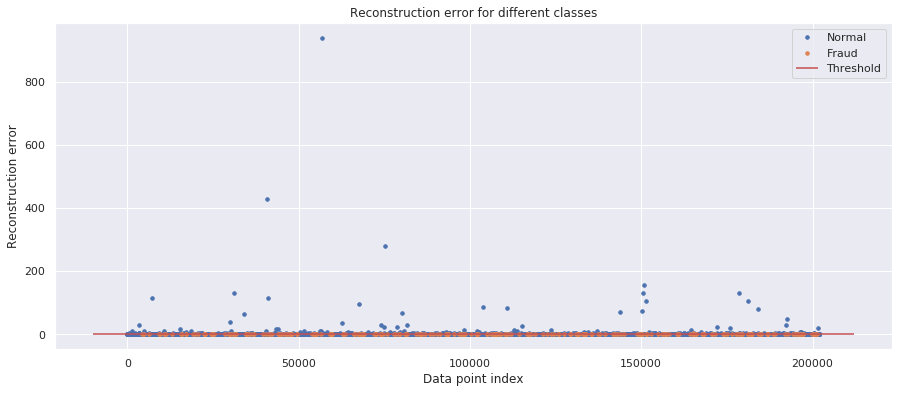

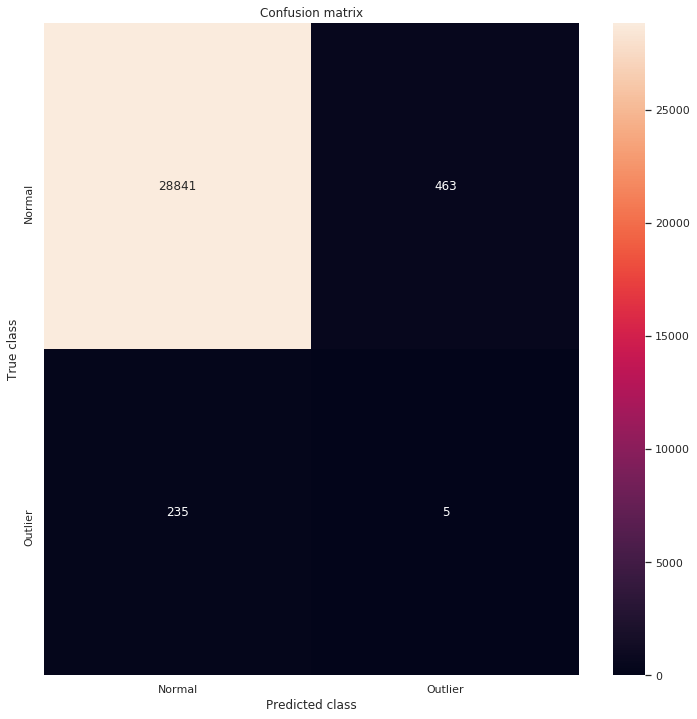

In [33]:
cols = ['feature_1', 'feature_2', 'feature_3', 'hist_authorized_flag_sum', 'hist_active_months_lag3_sum', 'hist_active_months_lag6_sum', 'hist_active_months_lag12_sum', 'hist_avg_sales_lag3_sum', 'hist_avg_sales_lag3_mean', 'hist_avg_sales_lag6_sum', 'hist_avg_sales_lag6_mean', 'hist_avg_sales_lag12_sum', 'hist_avg_sales_lag12_mean', 'hist_category_1_trans_sum', 'hist_category_1_merch_sum', 'hist_category_2_trans_sum', 'hist_category_2_trans_mean', 'hist_category_2_trans_nancnt', 'hist_category_2_trans_nanperc', 'hist_category_2_merch_sum', 'hist_category_2_merch_mean', 'hist_category_2_merch_nancnt', 'hist_category_2_merch_nanperc', 'hist_category_3_sum', 'hist_category_3_nanperc', 'hist_category_4_sum', 'hist_city_id_nunique', 'hist_city_id_mode', 'hist_installments_sum', 'hist_installments_mean', 'hist_installments_max', 'hist_installments_min', 'hist_installments_std', 'hist_installments_mode', 'hist_merchant_id_nunique', 'hist_merchant_id_nancnt', 'hist_merchant_category_id_trans_nunique', 'hist_merchant_category_id_trans_mode', 'hist_merchant_group_id_nunique', 'hist_merchant_group_id_mode', 'hist_merchant_category_id_merch_nunique', 'hist_merchant_category_id_merch_mode', 'hist_month_lag_min', 'hist_month_lag_max', 'hist_month_lag_mean', 'hist_most_recent_sales_range_sum', 'hist_most_recent_sales_range_max', 'hist_most_recent_sales_range_mode', 'hist_most_recent_purchases_range_sum', 'hist_most_recent_purchases_range_max', 'hist_most_recent_purchases_range_mode', 'hist_numerical_1_mean', 'hist_numerical_1_std', 'hist_numerical_1_mode', 'hist_numerical_2_mean', 'hist_numerical_2_std', 'hist_state_id_nunique', 'hist_state_id_mode', 'hist_subsector_id_trans_nunique', 'hist_subsector_id_trans_mode', 'hist_subsector_id_merch_nunique', 'hist_subsector_id_merch_mode', 'hist_purchase_amount_sum', 'hist_purchase_amount_mean', 'hist_purchase_amount_max', 'hist_purchase_amount_std', 'hist_purchase_year_mean', 'hist_purchase_year_median', 'hist_purchase_year_max', 'hist_purchase_year_mode', 'hist_purchase_month_mean', 'hist_purchase_month_median', 'hist_purchase_month_max', 'hist_purchase_month_min', 'hist_purchase_month_std', 'hist_purchase_month_mode', 'hist_purchase_day_mean', 'hist_purchase_day_median', 'hist_purchase_day_max', 'hist_purchase_day_min', 'hist_purchase_day_std', 'hist_purchase_day_mode', 'hist_purchase_hour_mean', 'hist_purchase_hour_median', 'hist_purchase_hour_max', 'hist_purchase_hour_min', 'hist_purchase_hour_std', 'hist_purchase_hour_mode', 'hist_purchase_weekofyear_mean', 'hist_purchase_weekofyear_median', 'hist_purchase_weekofyear_max', 'hist_purchase_weekofyear_min', 'hist_purchase_weekofyear_std', 'hist_purchase_weekofyear_mode', 'hist_purchase_dayofweek_median', 'hist_purchase_dayofweek_max', 'hist_purchase_dayofweek_min', 'hist_purchase_dayofweek_mode', 'hist_purchase_quarter_median', 'hist_purchase_quarter_max', 'hist_purchase_quarter_min', 'hist_purchase_quarter_mode', 'new_authorized_flag_sum', 'new_active_months_lag3_sum', 'new_active_months_lag3_mean', 'new_active_months_lag6_sum', 'new_active_months_lag12_sum', 'new_avg_sales_lag3_sum', 'new_avg_sales_lag3_mean', 'new_avg_sales_lag6_sum', 'new_avg_sales_lag6_mean', 'new_avg_sales_lag12_sum', 'new_avg_sales_lag12_mean', 'new_avg_purchases_lag3_sum', 'new_avg_purchases_lag3_mean', 'new_avg_purchases_lag6_sum', 'new_avg_purchases_lag6_mean', 'new_avg_purchases_lag12_sum', 'new_avg_purchases_lag12_mean', 'new_category_1_trans_sum', 'new_category_1_merch_sum', 'new_category_2_trans_sum', 'new_category_2_trans_mean', 'new_category_2_trans_nanperc', 'new_category_2_merch_sum', 'new_category_2_merch_nancnt', 'new_category_2_merch_nanperc', 'new_category_3_sum', 'new_category_3_nanperc', 'new_category_4_sum', 'new_city_id_nunique', 'new_city_id_mode', 'new_installments_sum', 'new_installments_max', 'new_installments_min', 'new_installments_mode', 'new_merchant_id_nunique', 'new_merchant_id_nancnt', 'new_merchant_id_nanperc', 'new_merchant_category_id_trans_nunique', 'new_merchant_category_id_trans_mode', 'new_merchant_group_id_nunique', 'new_merchant_group_id_mode', 'new_merchant_group_id_nanperc', 'new_merchant_category_id_merch_nunique', 'new_merchant_category_id_merch_mode', 'new_merchant_category_id_merch_nanperc', 'new_month_lag_min', 'new_month_lag_max', 'new_most_recent_sales_range_sum', 'new_most_recent_sales_range_max', 'new_most_recent_sales_range_mode', 'new_most_recent_purchases_range_sum', 'new_most_recent_purchases_range_max', 'new_most_recent_purchases_range_min', 'new_most_recent_purchases_range_mode', 'new_numerical_1_mean', 'new_numerical_1_median', 'new_numerical_1_max', 'new_numerical_1_std', 'new_numerical_2_mean', 'new_numerical_2_median', 'new_numerical_2_max', 'new_numerical_2_std', 'new_state_id_nunique', 'new_state_id_mode', 'new_subsector_id_trans_nunique', 'new_subsector_id_trans_mode', 'new_subsector_id_merch_nunique', 'new_subsector_id_merch_mode', 'new_subsector_id_merch_nanperc', 'new_purchase_amount_sum', 'new_purchase_year_mean', 'new_purchase_year_median', 'new_purchase_year_max', 'new_purchase_year_min', 'new_purchase_year_mode', 'new_purchase_month_mean', 'new_purchase_month_median', 'new_purchase_month_max', 'new_purchase_month_min', 'new_purchase_month_mode', 'new_purchase_day_mean', 'new_purchase_day_median', 'new_purchase_day_max', 'new_purchase_day_min', 'new_purchase_day_std', 'new_purchase_day_mode', 'new_purchase_hour_mean', 'new_purchase_hour_median', 'new_purchase_hour_max', 'new_purchase_hour_min', 'new_purchase_hour_std', 'new_purchase_hour_mode', 'new_purchase_weekofyear_mean', 'new_purchase_weekofyear_median', 'new_purchase_weekofyear_max', 'new_purchase_weekofyear_min', 'new_purchase_weekofyear_std', 'new_purchase_weekofyear_mode', 'new_purchase_dayofweek_mean', 'new_purchase_dayofweek_median', 'new_purchase_dayofweek_max', 'new_purchase_dayofweek_min', 'new_purchase_dayofweek_mode', 'new_purchase_quarter_mean', 'new_purchase_quarter_median', 'new_purchase_quarter_max', 'new_purchase_quarter_min', 'new_purchase_quarter_mode', 'is_outlier']
X_train, X_test, y_test = SplitIntoTrainTestSet(df_train, cols)

ae = setupAutoencoder(X_train.shape[1], 'tanh', [
    {'activation': 'relu', 'size': 50},
    {'activation': 'relu', 'size': 20},
], .001, verbose=True)

history = trainModel(ae, X_train, X_test)
plotModellLoss(history)

error_df = createReconstructionError(ae, X_test, y_test)
error_df.describe()

plotReconstructionErrors(error_df)
plotROCcurve(error_df)
precision, recall, th = plotRecallPrecisionCurve(error_df)
plotThresholdPrecisionCurve(th, precision)
threshold = 2
plotReconstructionErrorDataPoints(error_df, threshold)
drawConfusionMatrix(error_df, threshold)

### 3relu - 3relu (210 - 30 - 15 - 15 - 30 - 210)

There are 117,289 records and 210 fetures in the training set and 29,544 records and 210 fetures in the test set.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     (None, 210)               0         
_________________________________________________________________
dense_25 (Dense)             (None, 210)               44310     
_________________________________________________________________
dense_26 (Dense)             (None, 30)                6330      
_________________________________________________________________
dense_27 (Dense)             (None, 15)                465       
_________________________________________________________________
dense_28 (Dense)             (None, 15)                240       
_________________________________________________________________
dense_29 (Dense)             (None, 30)                480       
____________________________

Epoch 49/100
117289/117289 [==============================] - 10s 85us/step - loss: 0.7916 - acc: 0.1217 - val_loss: 0.8104 - val_acc: 0.1456
Epoch 50/100
117289/117289 [==============================] - 10s 87us/step - loss: 0.7922 - acc: 0.1227 - val_loss: 0.8038 - val_acc: 0.1532
Epoch 51/100
117289/117289 [==============================] - 11s 90us/step - loss: 0.7869 - acc: 0.1261 - val_loss: 0.8040 - val_acc: 0.0966
Epoch 52/100
117289/117289 [==============================] - 12s 99us/step - loss: 0.7884 - acc: 0.1254 - val_loss: 0.8004 - val_acc: 0.1500
Epoch 53/100
117289/117289 [==============================] - 11s 97us/step - loss: 0.7942 - acc: 0.1249 - val_loss: 0.8101 - val_acc: 0.1511
Epoch 54/100
117289/117289 [==============================] - 11s 97us/step - loss: 0.7868 - acc: 0.1247 - val_loss: 0.8065 - val_acc: 0.1526
Epoch 55/100
117289/117289 [==============================] - 11s 90us/step - loss: 0.7881 - acc: 0.1328 - val_loss: 0.8082 - val_acc: 0.0994
Epoch 

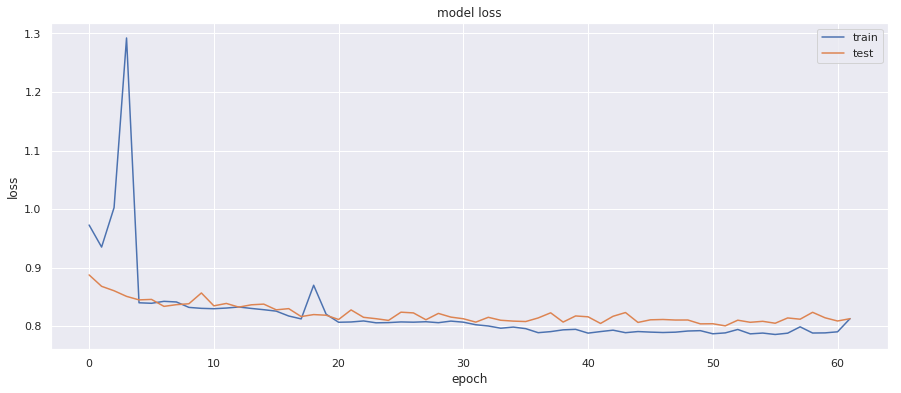

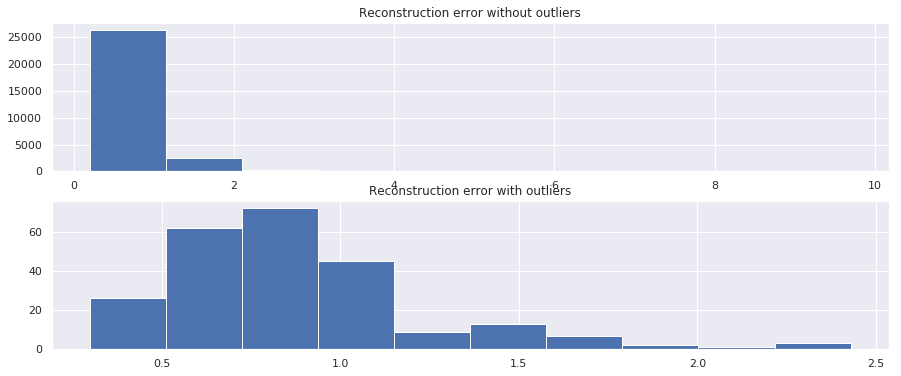

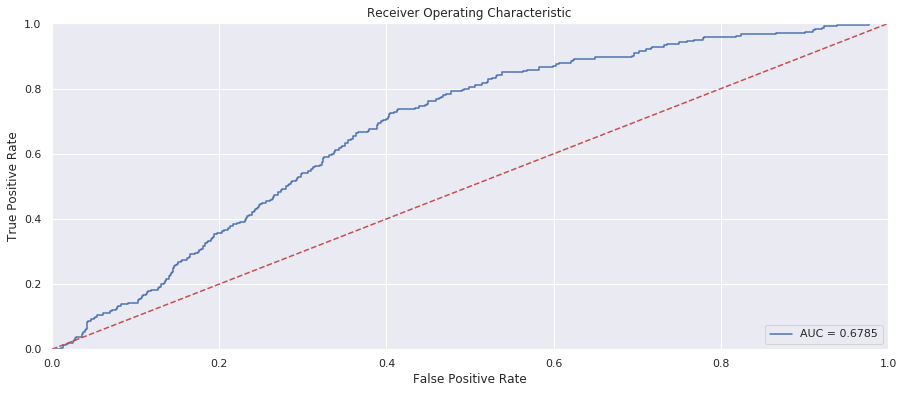

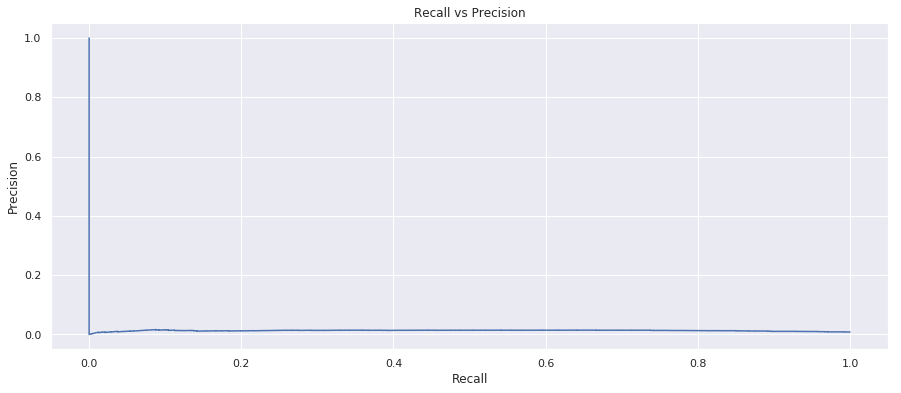

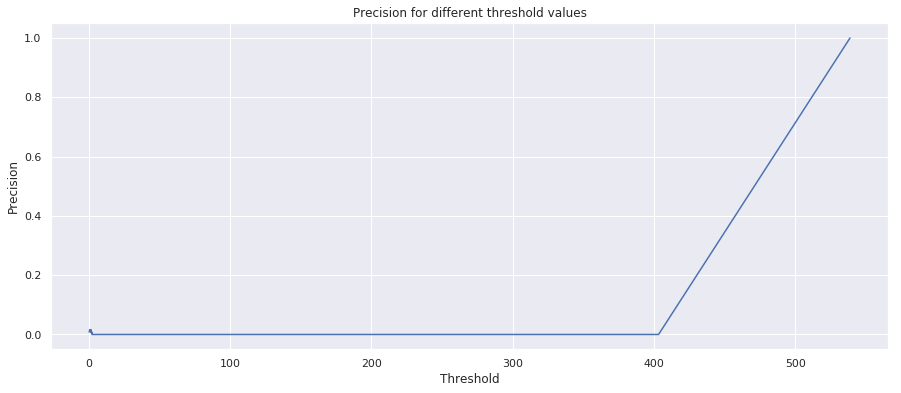

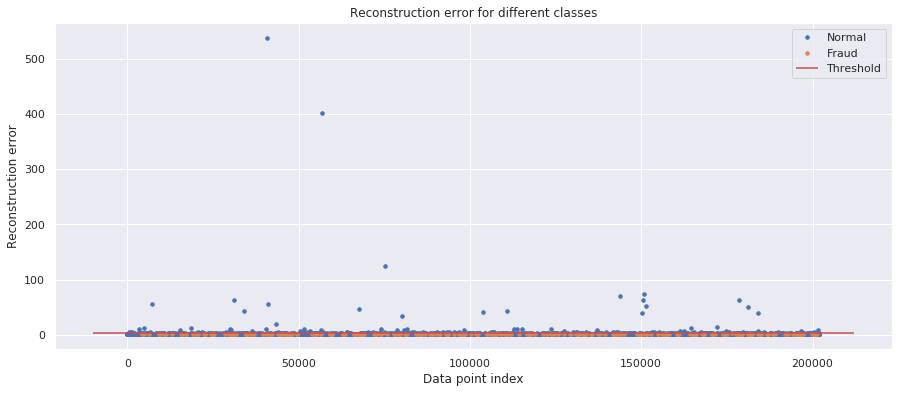

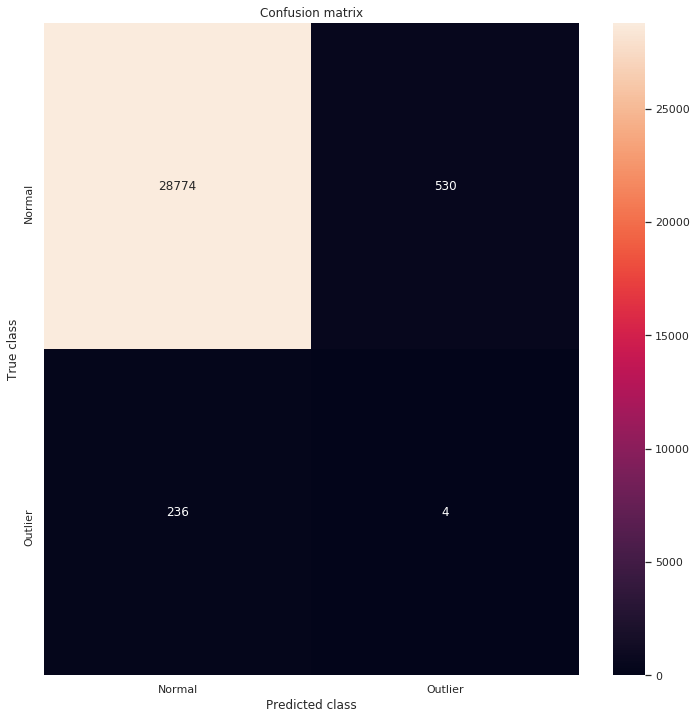

In [34]:
cols = ['feature_1', 'feature_2', 'feature_3', 'hist_authorized_flag_sum', 'hist_active_months_lag3_sum', 'hist_active_months_lag6_sum', 'hist_active_months_lag12_sum', 'hist_avg_sales_lag3_sum', 'hist_avg_sales_lag3_mean', 'hist_avg_sales_lag6_sum', 'hist_avg_sales_lag6_mean', 'hist_avg_sales_lag12_sum', 'hist_avg_sales_lag12_mean', 'hist_category_1_trans_sum', 'hist_category_1_merch_sum', 'hist_category_2_trans_sum', 'hist_category_2_trans_mean', 'hist_category_2_trans_nancnt', 'hist_category_2_trans_nanperc', 'hist_category_2_merch_sum', 'hist_category_2_merch_mean', 'hist_category_2_merch_nancnt', 'hist_category_2_merch_nanperc', 'hist_category_3_sum', 'hist_category_3_nanperc', 'hist_category_4_sum', 'hist_city_id_nunique', 'hist_city_id_mode', 'hist_installments_sum', 'hist_installments_mean', 'hist_installments_max', 'hist_installments_min', 'hist_installments_std', 'hist_installments_mode', 'hist_merchant_id_nunique', 'hist_merchant_id_nancnt', 'hist_merchant_category_id_trans_nunique', 'hist_merchant_category_id_trans_mode', 'hist_merchant_group_id_nunique', 'hist_merchant_group_id_mode', 'hist_merchant_category_id_merch_nunique', 'hist_merchant_category_id_merch_mode', 'hist_month_lag_min', 'hist_month_lag_max', 'hist_month_lag_mean', 'hist_most_recent_sales_range_sum', 'hist_most_recent_sales_range_max', 'hist_most_recent_sales_range_mode', 'hist_most_recent_purchases_range_sum', 'hist_most_recent_purchases_range_max', 'hist_most_recent_purchases_range_mode', 'hist_numerical_1_mean', 'hist_numerical_1_std', 'hist_numerical_1_mode', 'hist_numerical_2_mean', 'hist_numerical_2_std', 'hist_state_id_nunique', 'hist_state_id_mode', 'hist_subsector_id_trans_nunique', 'hist_subsector_id_trans_mode', 'hist_subsector_id_merch_nunique', 'hist_subsector_id_merch_mode', 'hist_purchase_amount_sum', 'hist_purchase_amount_mean', 'hist_purchase_amount_max', 'hist_purchase_amount_std', 'hist_purchase_year_mean', 'hist_purchase_year_median', 'hist_purchase_year_max', 'hist_purchase_year_mode', 'hist_purchase_month_mean', 'hist_purchase_month_median', 'hist_purchase_month_max', 'hist_purchase_month_min', 'hist_purchase_month_std', 'hist_purchase_month_mode', 'hist_purchase_day_mean', 'hist_purchase_day_median', 'hist_purchase_day_max', 'hist_purchase_day_min', 'hist_purchase_day_std', 'hist_purchase_day_mode', 'hist_purchase_hour_mean', 'hist_purchase_hour_median', 'hist_purchase_hour_max', 'hist_purchase_hour_min', 'hist_purchase_hour_std', 'hist_purchase_hour_mode', 'hist_purchase_weekofyear_mean', 'hist_purchase_weekofyear_median', 'hist_purchase_weekofyear_max', 'hist_purchase_weekofyear_min', 'hist_purchase_weekofyear_std', 'hist_purchase_weekofyear_mode', 'hist_purchase_dayofweek_median', 'hist_purchase_dayofweek_max', 'hist_purchase_dayofweek_min', 'hist_purchase_dayofweek_mode', 'hist_purchase_quarter_median', 'hist_purchase_quarter_max', 'hist_purchase_quarter_min', 'hist_purchase_quarter_mode', 'new_authorized_flag_sum', 'new_active_months_lag3_sum', 'new_active_months_lag3_mean', 'new_active_months_lag6_sum', 'new_active_months_lag12_sum', 'new_avg_sales_lag3_sum', 'new_avg_sales_lag3_mean', 'new_avg_sales_lag6_sum', 'new_avg_sales_lag6_mean', 'new_avg_sales_lag12_sum', 'new_avg_sales_lag12_mean', 'new_avg_purchases_lag3_sum', 'new_avg_purchases_lag3_mean', 'new_avg_purchases_lag6_sum', 'new_avg_purchases_lag6_mean', 'new_avg_purchases_lag12_sum', 'new_avg_purchases_lag12_mean', 'new_category_1_trans_sum', 'new_category_1_merch_sum', 'new_category_2_trans_sum', 'new_category_2_trans_mean', 'new_category_2_trans_nanperc', 'new_category_2_merch_sum', 'new_category_2_merch_nancnt', 'new_category_2_merch_nanperc', 'new_category_3_sum', 'new_category_3_nanperc', 'new_category_4_sum', 'new_city_id_nunique', 'new_city_id_mode', 'new_installments_sum', 'new_installments_max', 'new_installments_min', 'new_installments_mode', 'new_merchant_id_nunique', 'new_merchant_id_nancnt', 'new_merchant_id_nanperc', 'new_merchant_category_id_trans_nunique', 'new_merchant_category_id_trans_mode', 'new_merchant_group_id_nunique', 'new_merchant_group_id_mode', 'new_merchant_group_id_nanperc', 'new_merchant_category_id_merch_nunique', 'new_merchant_category_id_merch_mode', 'new_merchant_category_id_merch_nanperc', 'new_month_lag_min', 'new_month_lag_max', 'new_most_recent_sales_range_sum', 'new_most_recent_sales_range_max', 'new_most_recent_sales_range_mode', 'new_most_recent_purchases_range_sum', 'new_most_recent_purchases_range_max', 'new_most_recent_purchases_range_min', 'new_most_recent_purchases_range_mode', 'new_numerical_1_mean', 'new_numerical_1_median', 'new_numerical_1_max', 'new_numerical_1_std', 'new_numerical_2_mean', 'new_numerical_2_median', 'new_numerical_2_max', 'new_numerical_2_std', 'new_state_id_nunique', 'new_state_id_mode', 'new_subsector_id_trans_nunique', 'new_subsector_id_trans_mode', 'new_subsector_id_merch_nunique', 'new_subsector_id_merch_mode', 'new_subsector_id_merch_nanperc', 'new_purchase_amount_sum', 'new_purchase_year_mean', 'new_purchase_year_median', 'new_purchase_year_max', 'new_purchase_year_min', 'new_purchase_year_mode', 'new_purchase_month_mean', 'new_purchase_month_median', 'new_purchase_month_max', 'new_purchase_month_min', 'new_purchase_month_mode', 'new_purchase_day_mean', 'new_purchase_day_median', 'new_purchase_day_max', 'new_purchase_day_min', 'new_purchase_day_std', 'new_purchase_day_mode', 'new_purchase_hour_mean', 'new_purchase_hour_median', 'new_purchase_hour_max', 'new_purchase_hour_min', 'new_purchase_hour_std', 'new_purchase_hour_mode', 'new_purchase_weekofyear_mean', 'new_purchase_weekofyear_median', 'new_purchase_weekofyear_max', 'new_purchase_weekofyear_min', 'new_purchase_weekofyear_std', 'new_purchase_weekofyear_mode', 'new_purchase_dayofweek_mean', 'new_purchase_dayofweek_median', 'new_purchase_dayofweek_max', 'new_purchase_dayofweek_min', 'new_purchase_dayofweek_mode', 'new_purchase_quarter_mean', 'new_purchase_quarter_median', 'new_purchase_quarter_max', 'new_purchase_quarter_min', 'new_purchase_quarter_mode', 'is_outlier']
X_train, X_test, y_test = SplitIntoTrainTestSet(df_train, cols)

ae = setupAutoencoder(X_train.shape[1], 'relu', [
    {'activation': 'relu', 'size': 30},
    {'activation': 'relu', 'size': 15},
], .001, verbose=True)

history = trainModel(ae, X_train, X_test)
plotModellLoss(history)

error_df = createReconstructionError(ae, X_test, y_test)
error_df.describe()

plotReconstructionErrors(error_df)
plotROCcurve(error_df)
precision, recall, th = plotRecallPrecisionCurve(error_df)
plotThresholdPrecisionCurve(th, precision)
threshold = 2
plotReconstructionErrorDataPoints(error_df, threshold)
drawConfusionMatrix(error_df, threshold)

### 3tanh - 3tanh (210 - 50 - 20 - 20 - 50 - 210)

There are 117,289 records and 210 fetures in the training set and 29,544 records and 210 fetures in the test set.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     (None, 210)               0         
_________________________________________________________________
dense_30 (Dense)             (None, 210)               44310     
_________________________________________________________________
dense_31 (Dense)             (None, 30)                6330      
_________________________________________________________________
dense_32 (Dense)             (None, 15)                465       
_________________________________________________________________
dense_33 (Dense)             (None, 15)                240       
_________________________________________________________________
dense_34 (Dense)             (None, 30)                480       
____________________________

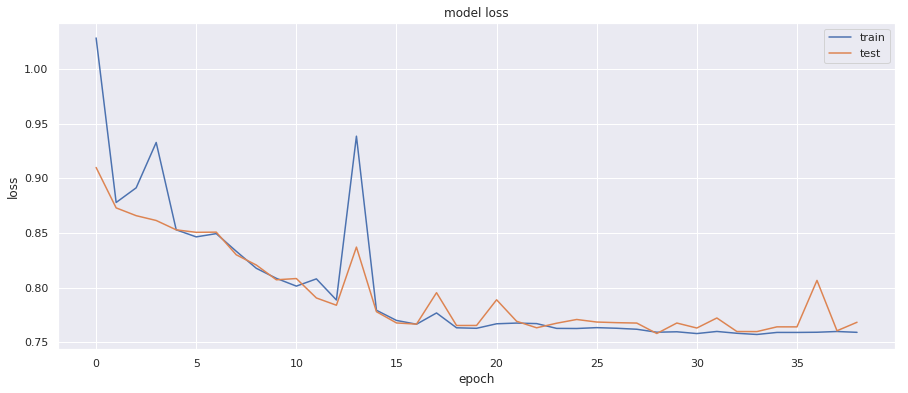

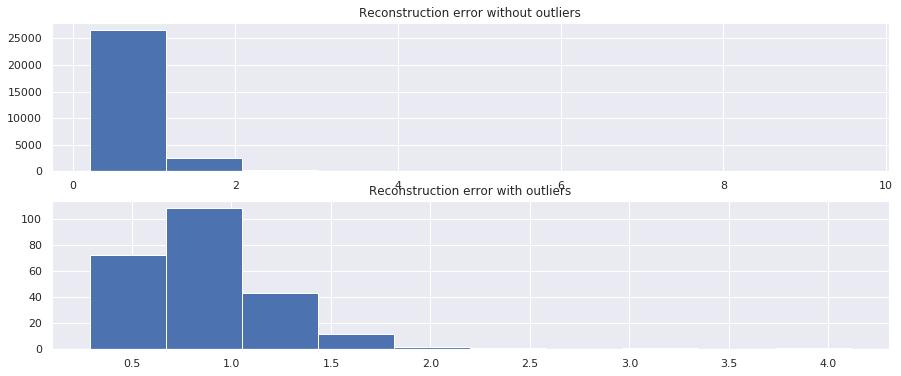

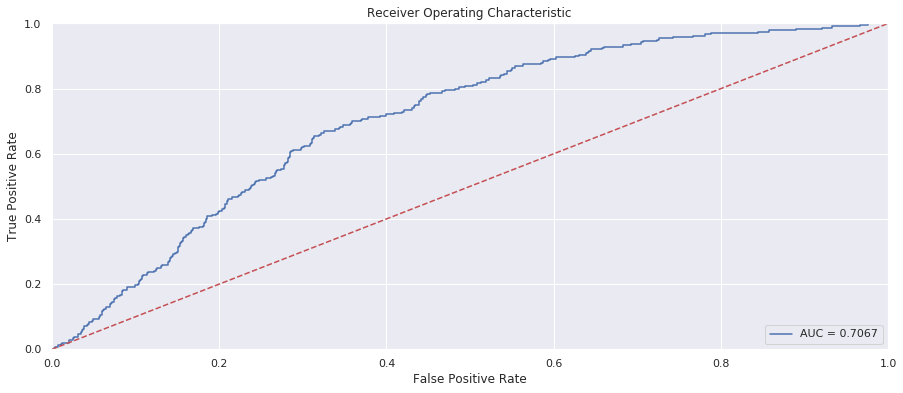

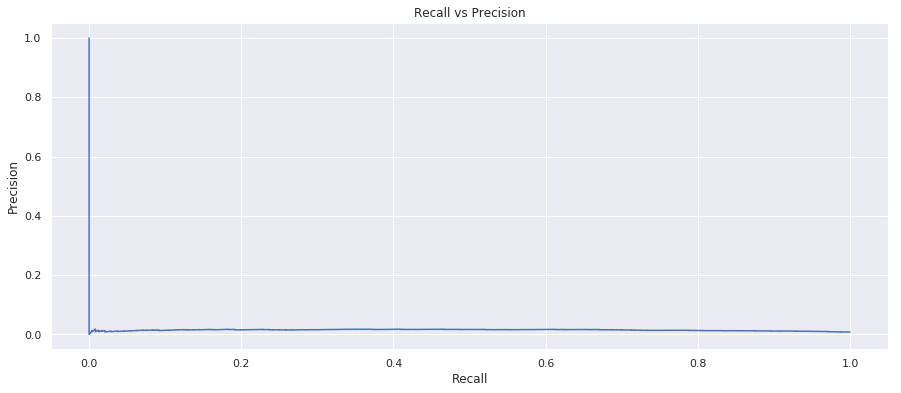

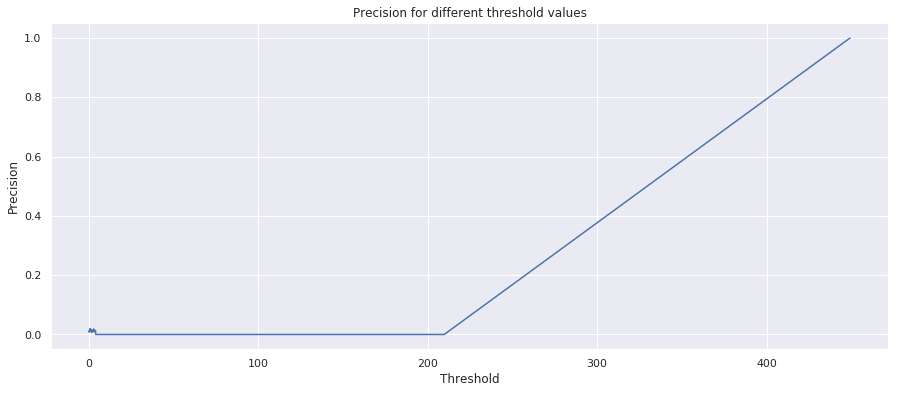

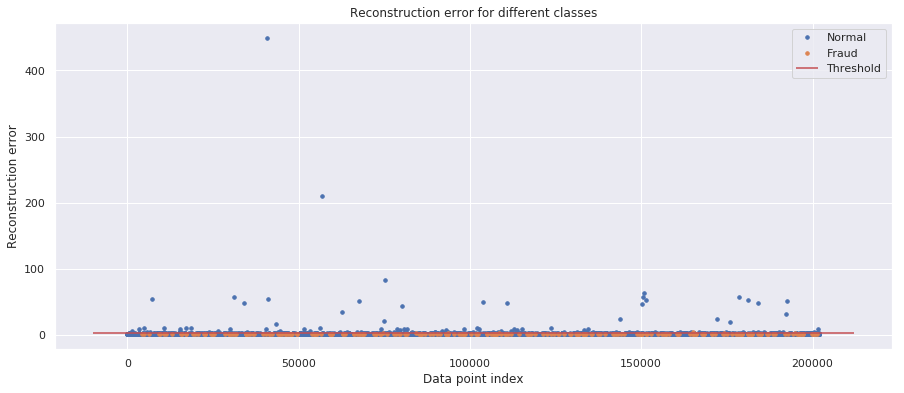

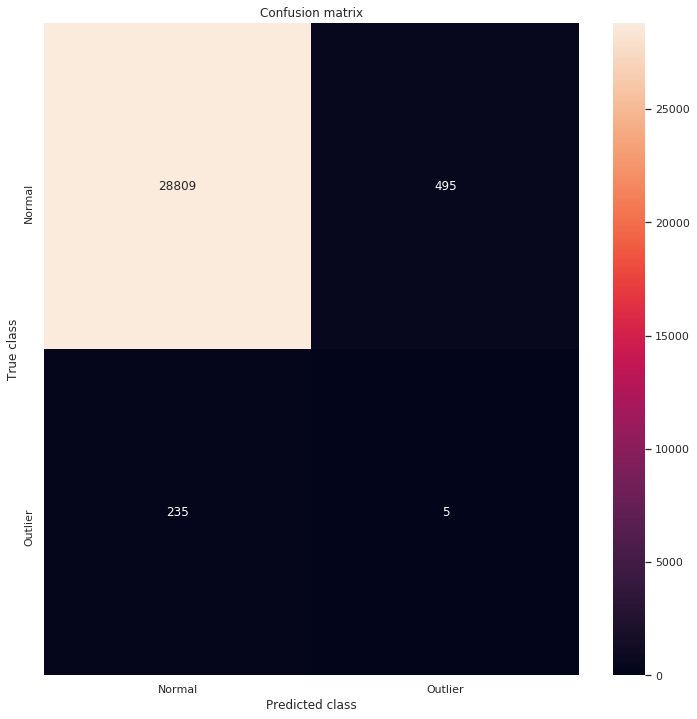

In [35]:
cols = ['feature_1', 'feature_2', 'feature_3', 'hist_authorized_flag_sum', 'hist_active_months_lag3_sum', 'hist_active_months_lag6_sum', 'hist_active_months_lag12_sum', 'hist_avg_sales_lag3_sum', 'hist_avg_sales_lag3_mean', 'hist_avg_sales_lag6_sum', 'hist_avg_sales_lag6_mean', 'hist_avg_sales_lag12_sum', 'hist_avg_sales_lag12_mean', 'hist_category_1_trans_sum', 'hist_category_1_merch_sum', 'hist_category_2_trans_sum', 'hist_category_2_trans_mean', 'hist_category_2_trans_nancnt', 'hist_category_2_trans_nanperc', 'hist_category_2_merch_sum', 'hist_category_2_merch_mean', 'hist_category_2_merch_nancnt', 'hist_category_2_merch_nanperc', 'hist_category_3_sum', 'hist_category_3_nanperc', 'hist_category_4_sum', 'hist_city_id_nunique', 'hist_city_id_mode', 'hist_installments_sum', 'hist_installments_mean', 'hist_installments_max', 'hist_installments_min', 'hist_installments_std', 'hist_installments_mode', 'hist_merchant_id_nunique', 'hist_merchant_id_nancnt', 'hist_merchant_category_id_trans_nunique', 'hist_merchant_category_id_trans_mode', 'hist_merchant_group_id_nunique', 'hist_merchant_group_id_mode', 'hist_merchant_category_id_merch_nunique', 'hist_merchant_category_id_merch_mode', 'hist_month_lag_min', 'hist_month_lag_max', 'hist_month_lag_mean', 'hist_most_recent_sales_range_sum', 'hist_most_recent_sales_range_max', 'hist_most_recent_sales_range_mode', 'hist_most_recent_purchases_range_sum', 'hist_most_recent_purchases_range_max', 'hist_most_recent_purchases_range_mode', 'hist_numerical_1_mean', 'hist_numerical_1_std', 'hist_numerical_1_mode', 'hist_numerical_2_mean', 'hist_numerical_2_std', 'hist_state_id_nunique', 'hist_state_id_mode', 'hist_subsector_id_trans_nunique', 'hist_subsector_id_trans_mode', 'hist_subsector_id_merch_nunique', 'hist_subsector_id_merch_mode', 'hist_purchase_amount_sum', 'hist_purchase_amount_mean', 'hist_purchase_amount_max', 'hist_purchase_amount_std', 'hist_purchase_year_mean', 'hist_purchase_year_median', 'hist_purchase_year_max', 'hist_purchase_year_mode', 'hist_purchase_month_mean', 'hist_purchase_month_median', 'hist_purchase_month_max', 'hist_purchase_month_min', 'hist_purchase_month_std', 'hist_purchase_month_mode', 'hist_purchase_day_mean', 'hist_purchase_day_median', 'hist_purchase_day_max', 'hist_purchase_day_min', 'hist_purchase_day_std', 'hist_purchase_day_mode', 'hist_purchase_hour_mean', 'hist_purchase_hour_median', 'hist_purchase_hour_max', 'hist_purchase_hour_min', 'hist_purchase_hour_std', 'hist_purchase_hour_mode', 'hist_purchase_weekofyear_mean', 'hist_purchase_weekofyear_median', 'hist_purchase_weekofyear_max', 'hist_purchase_weekofyear_min', 'hist_purchase_weekofyear_std', 'hist_purchase_weekofyear_mode', 'hist_purchase_dayofweek_median', 'hist_purchase_dayofweek_max', 'hist_purchase_dayofweek_min', 'hist_purchase_dayofweek_mode', 'hist_purchase_quarter_median', 'hist_purchase_quarter_max', 'hist_purchase_quarter_min', 'hist_purchase_quarter_mode', 'new_authorized_flag_sum', 'new_active_months_lag3_sum', 'new_active_months_lag3_mean', 'new_active_months_lag6_sum', 'new_active_months_lag12_sum', 'new_avg_sales_lag3_sum', 'new_avg_sales_lag3_mean', 'new_avg_sales_lag6_sum', 'new_avg_sales_lag6_mean', 'new_avg_sales_lag12_sum', 'new_avg_sales_lag12_mean', 'new_avg_purchases_lag3_sum', 'new_avg_purchases_lag3_mean', 'new_avg_purchases_lag6_sum', 'new_avg_purchases_lag6_mean', 'new_avg_purchases_lag12_sum', 'new_avg_purchases_lag12_mean', 'new_category_1_trans_sum', 'new_category_1_merch_sum', 'new_category_2_trans_sum', 'new_category_2_trans_mean', 'new_category_2_trans_nanperc', 'new_category_2_merch_sum', 'new_category_2_merch_nancnt', 'new_category_2_merch_nanperc', 'new_category_3_sum', 'new_category_3_nanperc', 'new_category_4_sum', 'new_city_id_nunique', 'new_city_id_mode', 'new_installments_sum', 'new_installments_max', 'new_installments_min', 'new_installments_mode', 'new_merchant_id_nunique', 'new_merchant_id_nancnt', 'new_merchant_id_nanperc', 'new_merchant_category_id_trans_nunique', 'new_merchant_category_id_trans_mode', 'new_merchant_group_id_nunique', 'new_merchant_group_id_mode', 'new_merchant_group_id_nanperc', 'new_merchant_category_id_merch_nunique', 'new_merchant_category_id_merch_mode', 'new_merchant_category_id_merch_nanperc', 'new_month_lag_min', 'new_month_lag_max', 'new_most_recent_sales_range_sum', 'new_most_recent_sales_range_max', 'new_most_recent_sales_range_mode', 'new_most_recent_purchases_range_sum', 'new_most_recent_purchases_range_max', 'new_most_recent_purchases_range_min', 'new_most_recent_purchases_range_mode', 'new_numerical_1_mean', 'new_numerical_1_median', 'new_numerical_1_max', 'new_numerical_1_std', 'new_numerical_2_mean', 'new_numerical_2_median', 'new_numerical_2_max', 'new_numerical_2_std', 'new_state_id_nunique', 'new_state_id_mode', 'new_subsector_id_trans_nunique', 'new_subsector_id_trans_mode', 'new_subsector_id_merch_nunique', 'new_subsector_id_merch_mode', 'new_subsector_id_merch_nanperc', 'new_purchase_amount_sum', 'new_purchase_year_mean', 'new_purchase_year_median', 'new_purchase_year_max', 'new_purchase_year_min', 'new_purchase_year_mode', 'new_purchase_month_mean', 'new_purchase_month_median', 'new_purchase_month_max', 'new_purchase_month_min', 'new_purchase_month_mode', 'new_purchase_day_mean', 'new_purchase_day_median', 'new_purchase_day_max', 'new_purchase_day_min', 'new_purchase_day_std', 'new_purchase_day_mode', 'new_purchase_hour_mean', 'new_purchase_hour_median', 'new_purchase_hour_max', 'new_purchase_hour_min', 'new_purchase_hour_std', 'new_purchase_hour_mode', 'new_purchase_weekofyear_mean', 'new_purchase_weekofyear_median', 'new_purchase_weekofyear_max', 'new_purchase_weekofyear_min', 'new_purchase_weekofyear_std', 'new_purchase_weekofyear_mode', 'new_purchase_dayofweek_mean', 'new_purchase_dayofweek_median', 'new_purchase_dayofweek_max', 'new_purchase_dayofweek_min', 'new_purchase_dayofweek_mode', 'new_purchase_quarter_mean', 'new_purchase_quarter_median', 'new_purchase_quarter_max', 'new_purchase_quarter_min', 'new_purchase_quarter_mode', 'is_outlier']
X_train, X_test, y_test = SplitIntoTrainTestSet(df_train, cols)

ae = setupAutoencoder(X_train.shape[1], 'relu', [
    {'activation': 'relu', 'size': 30},
    {'activation': 'relu', 'size': 15},
], .001, verbose=True)

history = trainModel(ae, X_train, X_test)
plotModellLoss(history)

error_df = createReconstructionError(ae, X_test, y_test)
error_df.describe()

plotReconstructionErrors(error_df)
plotROCcurve(error_df)
precision, recall, th = plotRecallPrecisionCurve(error_df)
plotThresholdPrecisionCurve(th, precision)
threshold = 1.8
plotReconstructionErrorDataPoints(error_df, threshold)
drawConfusionMatrix(error_df, threshold)

### 4relu - 4relu (210 - 60 - 30 - 20 - 20 - 30 - 60 - 210)

There are 117,289 records and 210 fetures in the training set and 29,544 records and 210 fetures in the test set.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     (None, 210)               0         
_________________________________________________________________
dense_35 (Dense)             (None, 210)               44310     
_________________________________________________________________
dense_36 (Dense)             (None, 60)                12660     
_________________________________________________________________
dense_37 (Dense)             (None, 30)                1830      
_________________________________________________________________
dense_38 (Dense)             (None, 20)                620       
_________________________________________________________________
dense_39 (Dense)             (None, 20)                420       
____________________________

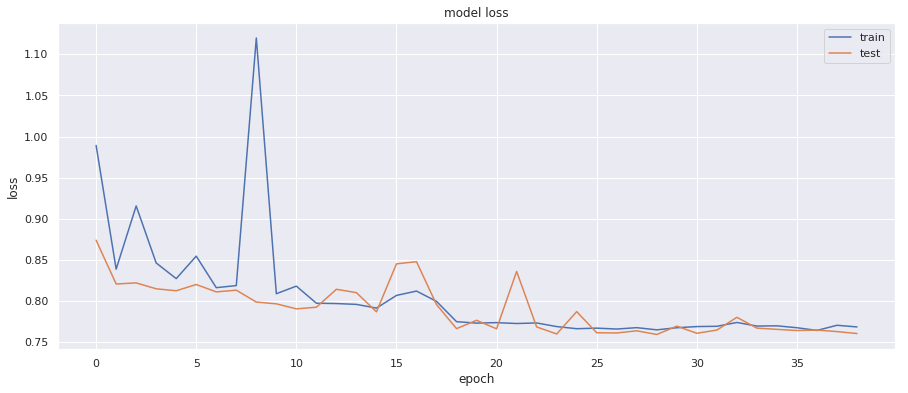

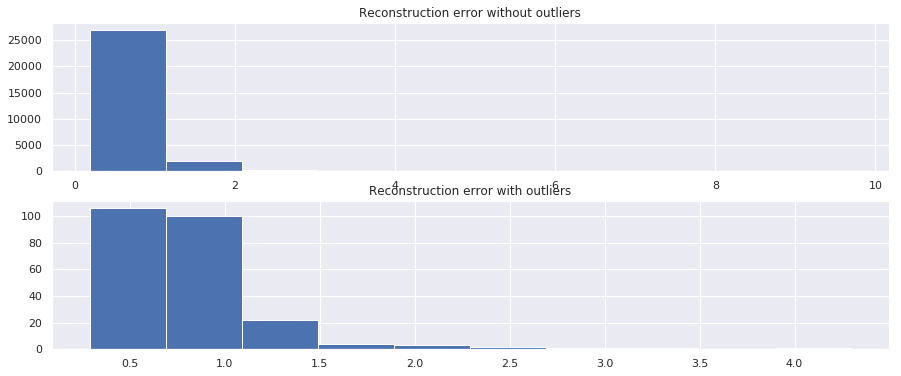

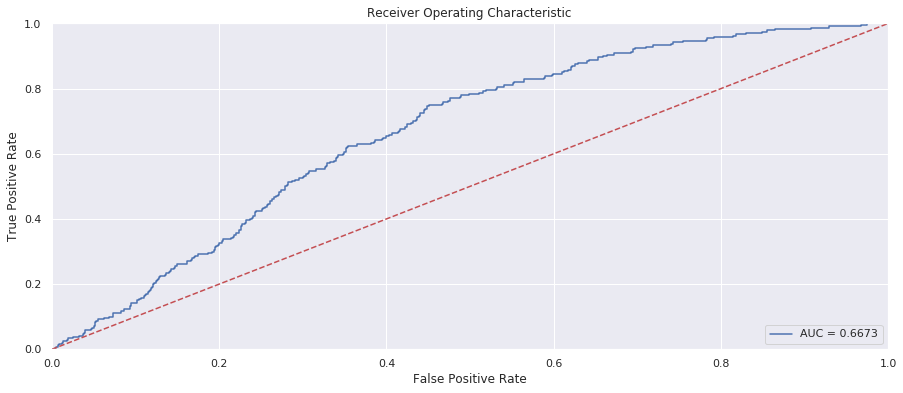

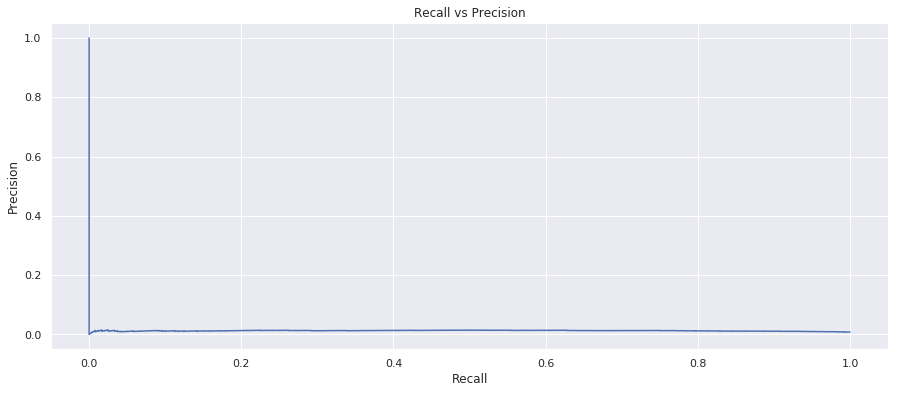

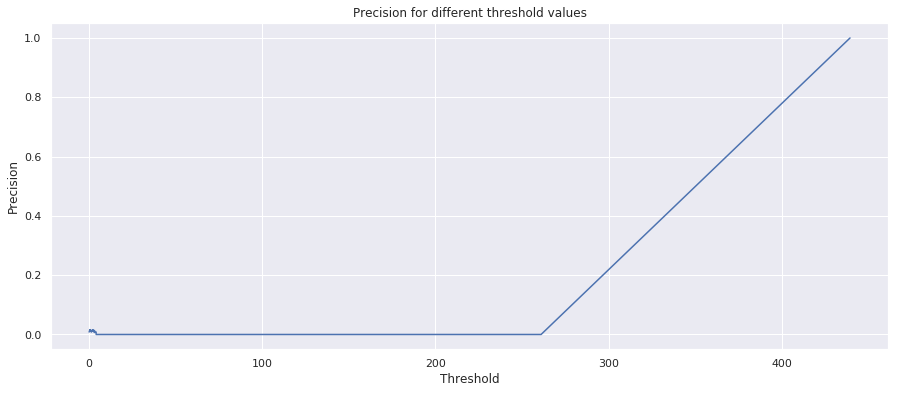

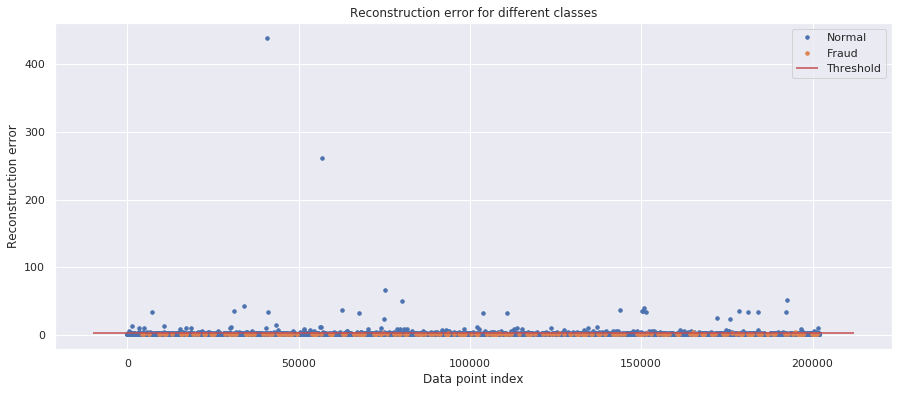

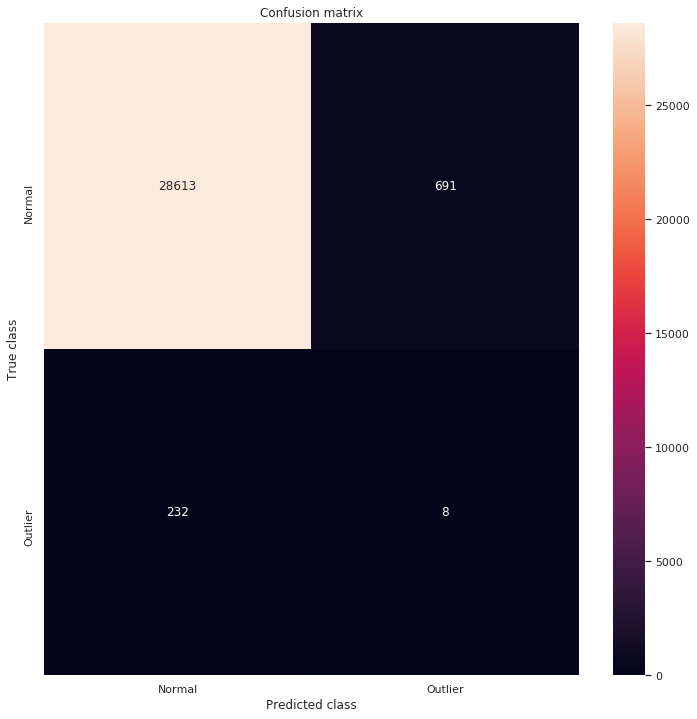

In [36]:
cols = ['feature_1', 'feature_2', 'feature_3', 'hist_authorized_flag_sum', 'hist_active_months_lag3_sum', 'hist_active_months_lag6_sum', 'hist_active_months_lag12_sum', 'hist_avg_sales_lag3_sum', 'hist_avg_sales_lag3_mean', 'hist_avg_sales_lag6_sum', 'hist_avg_sales_lag6_mean', 'hist_avg_sales_lag12_sum', 'hist_avg_sales_lag12_mean', 'hist_category_1_trans_sum', 'hist_category_1_merch_sum', 'hist_category_2_trans_sum', 'hist_category_2_trans_mean', 'hist_category_2_trans_nancnt', 'hist_category_2_trans_nanperc', 'hist_category_2_merch_sum', 'hist_category_2_merch_mean', 'hist_category_2_merch_nancnt', 'hist_category_2_merch_nanperc', 'hist_category_3_sum', 'hist_category_3_nanperc', 'hist_category_4_sum', 'hist_city_id_nunique', 'hist_city_id_mode', 'hist_installments_sum', 'hist_installments_mean', 'hist_installments_max', 'hist_installments_min', 'hist_installments_std', 'hist_installments_mode', 'hist_merchant_id_nunique', 'hist_merchant_id_nancnt', 'hist_merchant_category_id_trans_nunique', 'hist_merchant_category_id_trans_mode', 'hist_merchant_group_id_nunique', 'hist_merchant_group_id_mode', 'hist_merchant_category_id_merch_nunique', 'hist_merchant_category_id_merch_mode', 'hist_month_lag_min', 'hist_month_lag_max', 'hist_month_lag_mean', 'hist_most_recent_sales_range_sum', 'hist_most_recent_sales_range_max', 'hist_most_recent_sales_range_mode', 'hist_most_recent_purchases_range_sum', 'hist_most_recent_purchases_range_max', 'hist_most_recent_purchases_range_mode', 'hist_numerical_1_mean', 'hist_numerical_1_std', 'hist_numerical_1_mode', 'hist_numerical_2_mean', 'hist_numerical_2_std', 'hist_state_id_nunique', 'hist_state_id_mode', 'hist_subsector_id_trans_nunique', 'hist_subsector_id_trans_mode', 'hist_subsector_id_merch_nunique', 'hist_subsector_id_merch_mode', 'hist_purchase_amount_sum', 'hist_purchase_amount_mean', 'hist_purchase_amount_max', 'hist_purchase_amount_std', 'hist_purchase_year_mean', 'hist_purchase_year_median', 'hist_purchase_year_max', 'hist_purchase_year_mode', 'hist_purchase_month_mean', 'hist_purchase_month_median', 'hist_purchase_month_max', 'hist_purchase_month_min', 'hist_purchase_month_std', 'hist_purchase_month_mode', 'hist_purchase_day_mean', 'hist_purchase_day_median', 'hist_purchase_day_max', 'hist_purchase_day_min', 'hist_purchase_day_std', 'hist_purchase_day_mode', 'hist_purchase_hour_mean', 'hist_purchase_hour_median', 'hist_purchase_hour_max', 'hist_purchase_hour_min', 'hist_purchase_hour_std', 'hist_purchase_hour_mode', 'hist_purchase_weekofyear_mean', 'hist_purchase_weekofyear_median', 'hist_purchase_weekofyear_max', 'hist_purchase_weekofyear_min', 'hist_purchase_weekofyear_std', 'hist_purchase_weekofyear_mode', 'hist_purchase_dayofweek_median', 'hist_purchase_dayofweek_max', 'hist_purchase_dayofweek_min', 'hist_purchase_dayofweek_mode', 'hist_purchase_quarter_median', 'hist_purchase_quarter_max', 'hist_purchase_quarter_min', 'hist_purchase_quarter_mode', 'new_authorized_flag_sum', 'new_active_months_lag3_sum', 'new_active_months_lag3_mean', 'new_active_months_lag6_sum', 'new_active_months_lag12_sum', 'new_avg_sales_lag3_sum', 'new_avg_sales_lag3_mean', 'new_avg_sales_lag6_sum', 'new_avg_sales_lag6_mean', 'new_avg_sales_lag12_sum', 'new_avg_sales_lag12_mean', 'new_avg_purchases_lag3_sum', 'new_avg_purchases_lag3_mean', 'new_avg_purchases_lag6_sum', 'new_avg_purchases_lag6_mean', 'new_avg_purchases_lag12_sum', 'new_avg_purchases_lag12_mean', 'new_category_1_trans_sum', 'new_category_1_merch_sum', 'new_category_2_trans_sum', 'new_category_2_trans_mean', 'new_category_2_trans_nanperc', 'new_category_2_merch_sum', 'new_category_2_merch_nancnt', 'new_category_2_merch_nanperc', 'new_category_3_sum', 'new_category_3_nanperc', 'new_category_4_sum', 'new_city_id_nunique', 'new_city_id_mode', 'new_installments_sum', 'new_installments_max', 'new_installments_min', 'new_installments_mode', 'new_merchant_id_nunique', 'new_merchant_id_nancnt', 'new_merchant_id_nanperc', 'new_merchant_category_id_trans_nunique', 'new_merchant_category_id_trans_mode', 'new_merchant_group_id_nunique', 'new_merchant_group_id_mode', 'new_merchant_group_id_nanperc', 'new_merchant_category_id_merch_nunique', 'new_merchant_category_id_merch_mode', 'new_merchant_category_id_merch_nanperc', 'new_month_lag_min', 'new_month_lag_max', 'new_most_recent_sales_range_sum', 'new_most_recent_sales_range_max', 'new_most_recent_sales_range_mode', 'new_most_recent_purchases_range_sum', 'new_most_recent_purchases_range_max', 'new_most_recent_purchases_range_min', 'new_most_recent_purchases_range_mode', 'new_numerical_1_mean', 'new_numerical_1_median', 'new_numerical_1_max', 'new_numerical_1_std', 'new_numerical_2_mean', 'new_numerical_2_median', 'new_numerical_2_max', 'new_numerical_2_std', 'new_state_id_nunique', 'new_state_id_mode', 'new_subsector_id_trans_nunique', 'new_subsector_id_trans_mode', 'new_subsector_id_merch_nunique', 'new_subsector_id_merch_mode', 'new_subsector_id_merch_nanperc', 'new_purchase_amount_sum', 'new_purchase_year_mean', 'new_purchase_year_median', 'new_purchase_year_max', 'new_purchase_year_min', 'new_purchase_year_mode', 'new_purchase_month_mean', 'new_purchase_month_median', 'new_purchase_month_max', 'new_purchase_month_min', 'new_purchase_month_mode', 'new_purchase_day_mean', 'new_purchase_day_median', 'new_purchase_day_max', 'new_purchase_day_min', 'new_purchase_day_std', 'new_purchase_day_mode', 'new_purchase_hour_mean', 'new_purchase_hour_median', 'new_purchase_hour_max', 'new_purchase_hour_min', 'new_purchase_hour_std', 'new_purchase_hour_mode', 'new_purchase_weekofyear_mean', 'new_purchase_weekofyear_median', 'new_purchase_weekofyear_max', 'new_purchase_weekofyear_min', 'new_purchase_weekofyear_std', 'new_purchase_weekofyear_mode', 'new_purchase_dayofweek_mean', 'new_purchase_dayofweek_median', 'new_purchase_dayofweek_max', 'new_purchase_dayofweek_min', 'new_purchase_dayofweek_mode', 'new_purchase_quarter_mean', 'new_purchase_quarter_median', 'new_purchase_quarter_max', 'new_purchase_quarter_min', 'new_purchase_quarter_mode', 'is_outlier']
X_train, X_test, y_test = SplitIntoTrainTestSet(df_train, cols)

ae = setupAutoencoder(X_train.shape[1], 'relu', [
    {'activation': 'relu', 'size': 60},
    {'activation': 'relu', 'size': 30},
    {'activation': 'relu', 'size': 20},
], .001, verbose=True)

history = trainModel(ae, X_train, X_test)
plotModellLoss(history)

error_df = createReconstructionError(ae, X_test, y_test)
error_df.describe()

plotReconstructionErrors(error_df)
plotROCcurve(error_df)
precision, recall, th = plotRecallPrecisionCurve(error_df)
plotThresholdPrecisionCurve(th, precision)
threshold = 1.9
plotReconstructionErrorDataPoints(error_df, threshold)
drawConfusionMatrix(error_df, threshold)

"nem az outliereknél a legnagyobb a hiba". Honnan látszik?